In [1]:
from argparse import ArgumentParser

import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from preprocessing.data_pipeline import build_data_pipeline
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from preprocessing.preprocess_ucr import UCRDatasetImporter
from experiments.exp_maskgit import ExpMaskGIT
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt


from models.stage2.maskgit import MaskGIT
import os
from pathlib import Path
import tempfile

# from evaluation.evaluation import Evaluation
from utils import (
    get_root_dir,
    load_yaml_param_settings,
    save_model,
    model_filename,
)

dataset = "TwoPatterns" 
config_dir = get_root_dir().joinpath("configs", "config.yaml")
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = dataset

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]

train_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

test_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="test"
)

input_length = train_data_loader_no_aug.dataset.X.shape[-1]

n_classes = len(np.unique(train_data_loader_no_aug.dataset.Y))

maskgit = MaskGIT(
    input_length,
    **config["MaskGIT"],
    config=config,
    n_classes=n_classes,
)

# load
fname = f"maskgit-{dataset}.ckpt"
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
    
print("maskgit loaded")

self.X_train.shape: (1000, 128)
self.X_test.shape: (4000, 128)
# unique labels (train): [0 1 2 3]
# unique labels (test): [0 1 2 3]
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
encoder-TwoPatterns.ckpt
 encoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
decoder-TwoPatterns.ckpt
 decoder loaded
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Master/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-TwoPatterns.ckpt
 vqmodel loaded
maskgit loaded


In [5]:
maskgit.mask_token_ids

32

In [6]:
s = torch.tensor([[1,1,1,1],[1,1,1,1],[1,1,1,1]])
print(s.shape)
n_masks = 2
rand = torch.rand(s.shape)  # (b n)
print(rand)
mask = torch.zeros(s.shape, dtype=torch.bool)
print(mask)
mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

masked_indices = maskgit.mask_token_ids * torch.ones_like(
            s
        )  # (b n)
s_M = mask * s + (~mask) * masked_indices  # (b n); `~` reverses bool-typed data
s_M

torch.Size([3, 4])
tensor([[0.0054, 0.7198, 0.1739, 0.1912],
        [0.9787, 0.9811, 0.0307, 0.6854],
        [0.3114, 0.8559, 0.4937, 0.8090]])
tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])


tensor([[32,  1, 32,  1],
        [ 1,  1, 32, 32],
        [32,  1, 32,  1]])

In [8]:
s_array, probs, entropy, sel_entropy = maskgit.iterative_decoding(stats=True)

In [ ]:
confidence_array[0].shape

torch.Size([1, 40])

In [ ]:
seq_len = s_array[0].shape[-1]

In [ ]:
k_array = []
for i in mask_len_array:
    k_array.append(seq_len-i)

In [1]:
confidence_array[0].shape
mask_len_array
k_array

NameError: name 'confidence_array' is not defined

In [25]:
# confidence = confidence_array[9]
# mask_len = mask_len_array[9]
# print(mask_len)
# top = torch.topk(confidence, seq_len - mask_len, largest = True)[0] #Values
# bottom = torch.topk(confidence, mask_len, largest = False)[0] #Values
# bottom_top = torch.topk(top, 1, largest = False)[0]
# # top_bottom = torch.topk(bottom, 1, largest = True)[0]
# print("top:", top)
# print("bottom:", bottom)
# print("bottom_top:", bottom_top)
# print("top_bottom:", top_bottom)
# diff = bottom_top - top_bottom


In [26]:
def conf_diff(confidence, mask_len, seq_len): 
    if mask_len == 0:
        #When all tokens are selected. Nothing to compare
        return    
    top = torch.topk(confidence, seq_len - mask_len, largest = True)[0] #Values
    bottom = torch.topk(confidence, mask_len, largest = False)[0] #Values
    bottom_top = torch.topk(top, 1, largest = False)[0]
    top_bottom = torch.topk(bottom, 1, largest = True)[0]
    diff = bottom_top - top_bottom
    
    # print("top:", top[[torch.isfinite(top)]])
    # print("bottom:", bottom)
    # print("bottom_top:", bottom_top)
    # print("top_bottom:", top_bottom)
    
    return diff




In [27]:
seq_len = confidence_array[0].shape[-1]

In [28]:
seq_len = confidence_array[0].shape[-1]
for i in range(10):
    print(conf_diff(confidence_array[i], mask_len_array[i], seq_len))
    print(mask_len_array[i])
    print(i)
    print('----------')

tensor([[2.9491]])
39
0
----------
tensor([[11.4009]])
38
1
----------
tensor([[2.2849]])
35
2
----------
tensor([[1.7093]])
32
3
----------
tensor([[0.6384]])
28
4
----------
tensor([[0.2246]])
23
5
----------
tensor([[0.5550]])
18
6
----------
tensor([[0.0939]])
12
7
----------
tensor([[0.8219]])
6
8
----------
None
0
9
----------


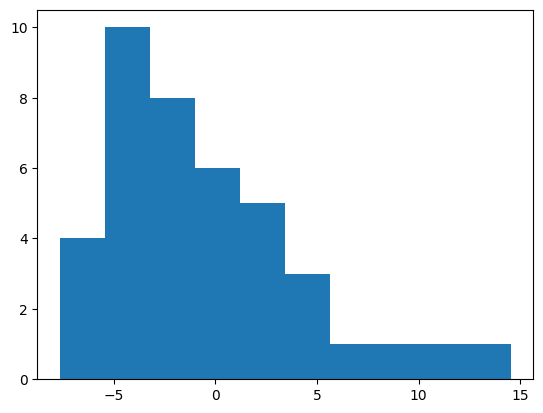

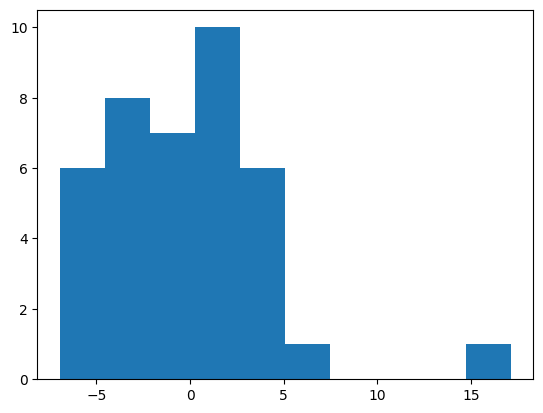

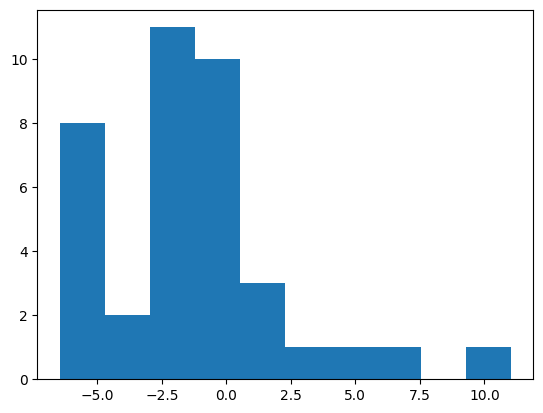

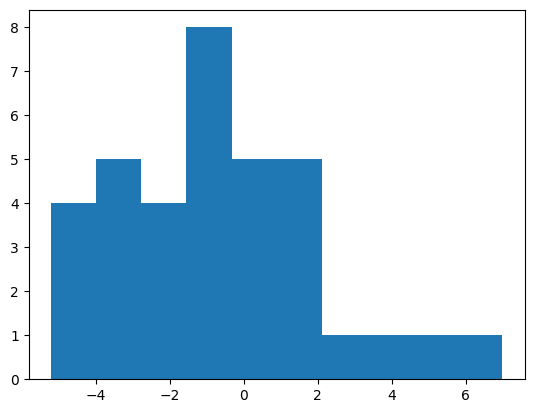

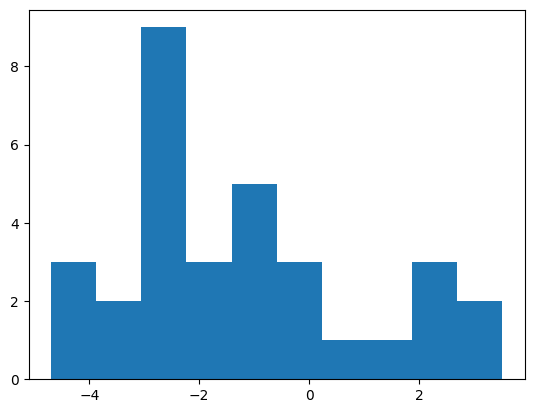

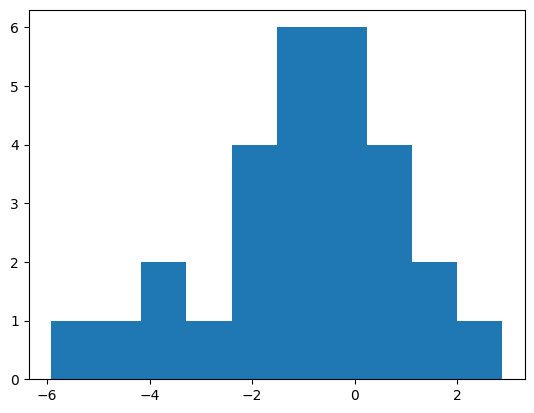

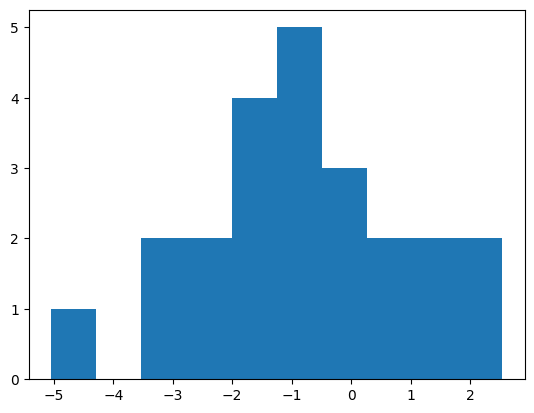

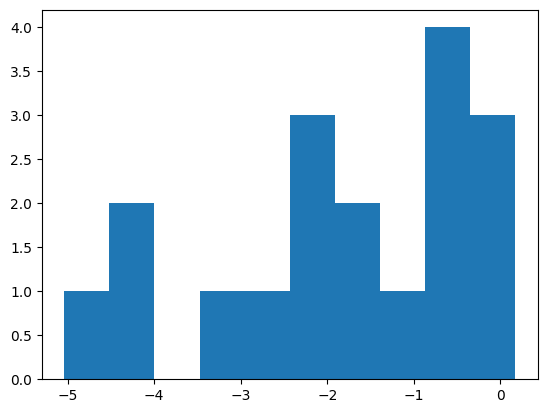

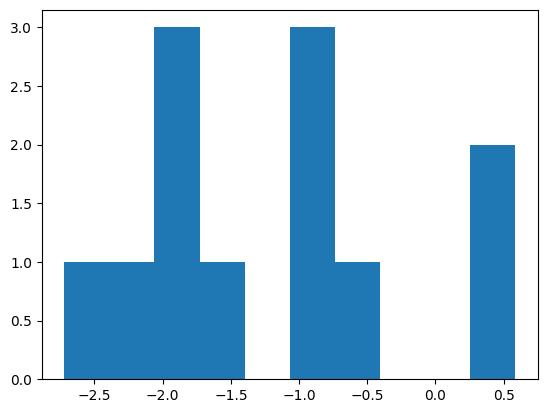

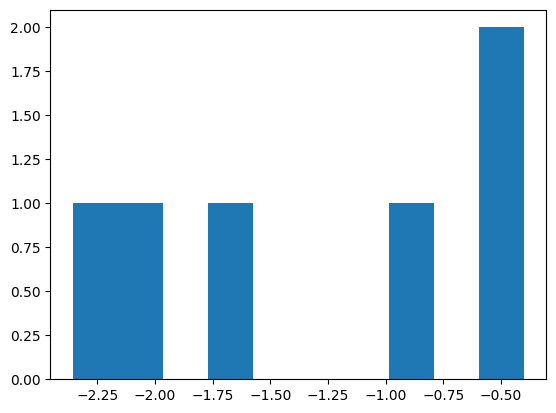

In [29]:
for i in range(10):
    plt.hist(confidence_array[i][[torch.isfinite(confidence_array[i])]], label = "Confidence")
    plt.show()

In [30]:
torch.topk(confidence_array[0], mask_len_array[0]+1, largest = False)[0]

tensor([[-7.6440, -7.6204, -5.7680, -5.6815, -5.4256, -5.0010, -4.7907, -4.7462,
         -4.6526, -4.2081, -4.0458, -3.8310, -3.6976, -3.5764, -2.7367, -2.2969,
         -2.0456, -1.9106, -1.8546, -1.6008, -1.3603, -1.0090, -0.9863, -0.7221,
         -0.5953,  0.2648,  0.3876,  1.2045,  1.7842,  1.8539,  1.9200,  2.8250,
          3.1543,  3.5693,  3.9827,  5.1413,  5.8973, 10.0467, 11.5856, 14.5347]])

In [31]:
prob_tensor[0].shape


torch.Size([1, 40, 32])

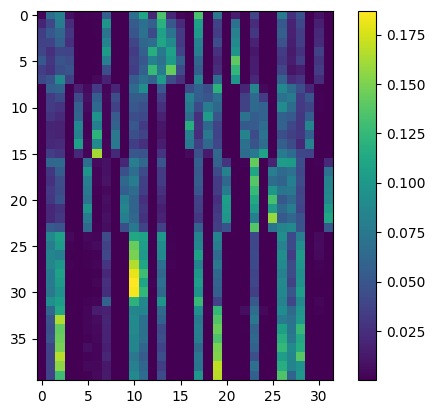

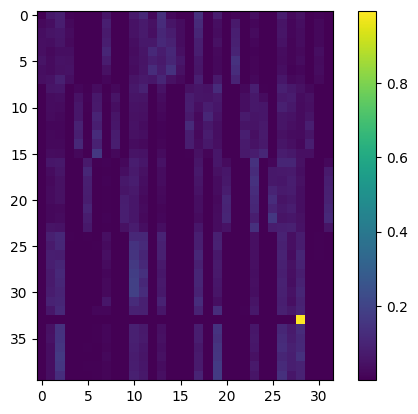

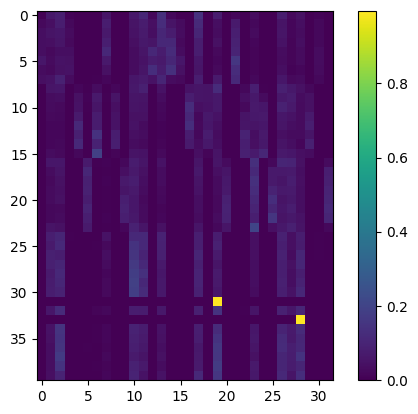

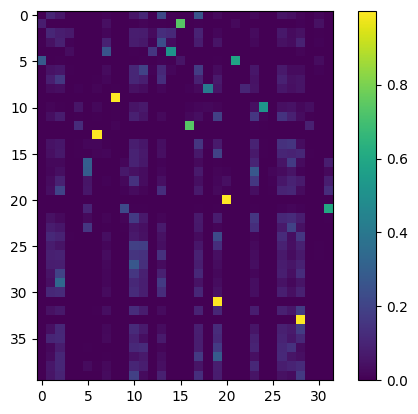

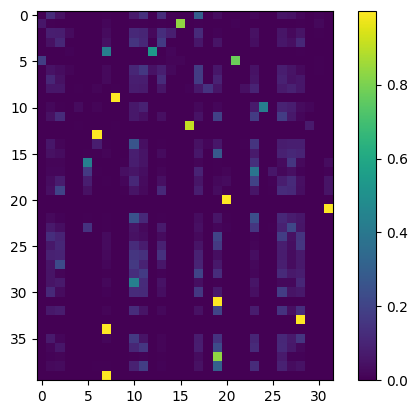

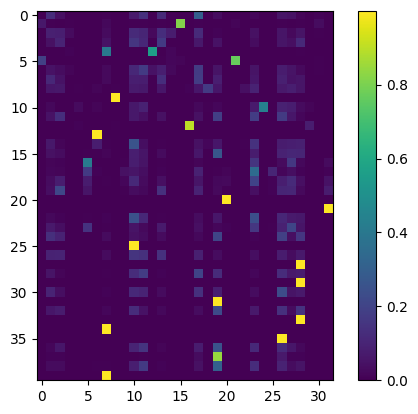

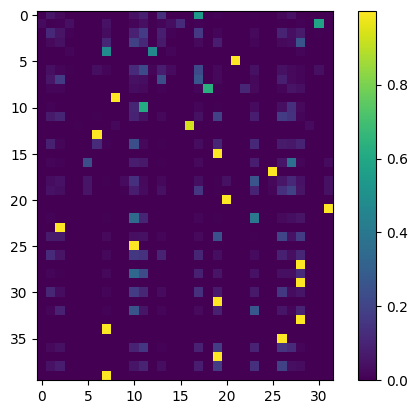

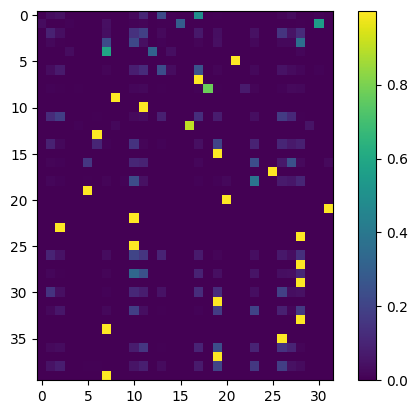

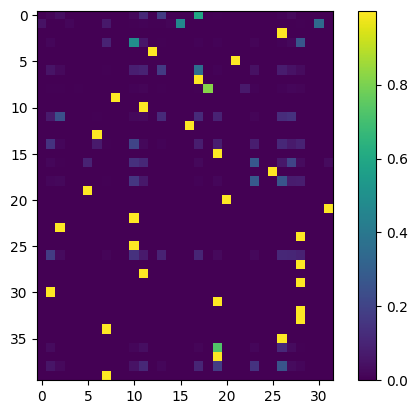

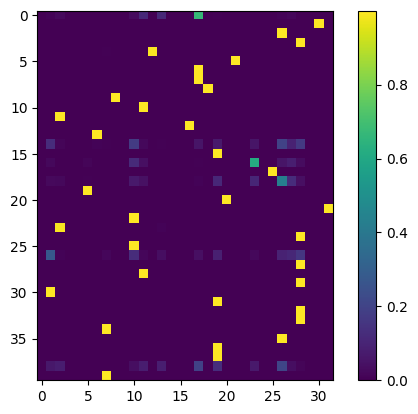

In [32]:
for i in range(10):
    plt.imshow(prob_tensor[i][0])
    plt.colorbar()
    plt.show()


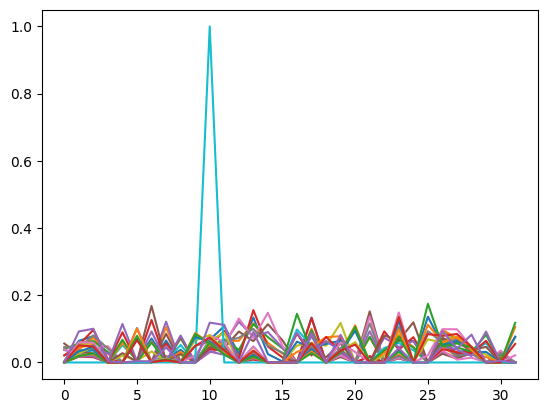

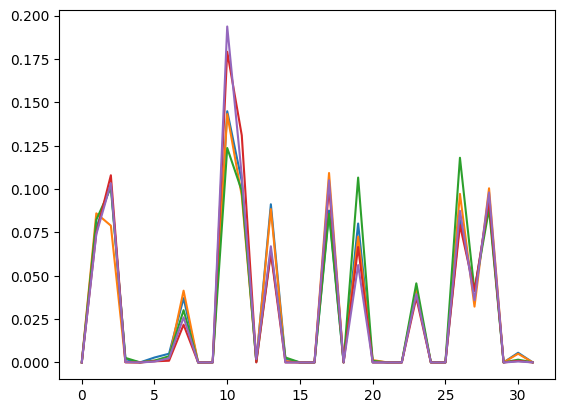

IndexError: index 40 is out of bounds for dimension 0 with size 40

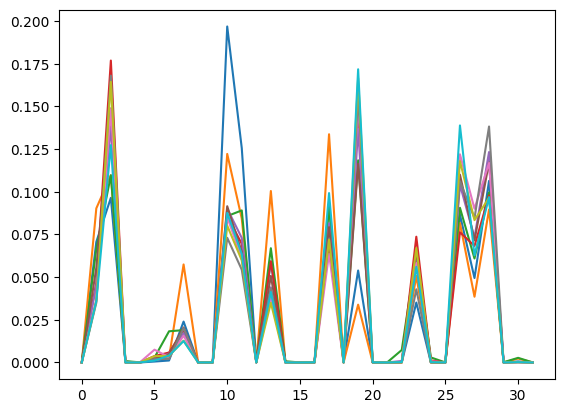

In [204]:
sample = 1

for i in range(25):
    plt.plot(prob_tensor[sample][0][i][:])
    
plt.show()
for i in range(25,30):
    plt.plot(prob_tensor[sample][0][i][:])

# title = 'collection of pmfs for token sampling', xlabel = 'Codebook Index', ylabel = 'probability')
plt.show()

for i in range(30,75):
    plt.plot(prob_tensor[sample][0][i][:])
plt.show()

In [ ]:
from tqdm import tqdm

# Visualize mean probability as a function of iteration number t
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def aggregate_iterative_decoding(maskgit, num_iterations=10, finite=True):
    results = []
    aggregated_mask_len =[]
    for _ in tqdm(range(num_iterations)):
        _, probs_array, entropy_array, sel_entropy_array, prob_tensor_array, confidence_array, mask_len_array = maskgit.iterative_decoding(stats=True)
        aggregated_mask_len.append(mask_len_array)
        results.append((probs_array, entropy_array, sel_entropy_array, prob_tensor_array, confidence_array))

    # Aggregate results across iterations-
    aggregated_probs = torch.stack([torch.stack(probs) for probs, _, _, _, _ in results])
    aggregated_entropy = torch.stack([torch.stack(entropy) for _, entropy, _, _, _ in results])
    aggregated_sel_entropy = torch.stack([torch.stack(sel_entropy) for _, _, sel_entropy, _, _ in results])
    
    aggregated_prob_tensor= torch.stack([torch.stack(prob_tensor) for _, _, _,prob_tensor, _  in results])
    aggregated_confidence = torch.stack([torch.stack(confidence) for _, _, _,_,confidence in results])
    
    #broadcasting: (num_iterations, t, 1, num tokens) -> (num_iterations, t, num_tokens)
    aggregated_probs = torch.squeeze(aggregated_probs, dim=2)
    aggregated_entropy = torch.squeeze(aggregated_entropy, dim=2)
    #aggregated_sel_entropy = torch.squeeze(aggregated_sel_entropy, dim=2)

    aggregated_prob_tensor = torch.squeeze(aggregated_prob_tensor, dim=2)
    aggregated_confidence = torch.squeeze(aggregated_confidence, dim=2)

    
    return aggregated_probs, aggregated_entropy, aggregated_sel_entropy, aggregated_prob_tensor, aggregated_confidence, aggregated_mask_len

# Example usage
aggregated_probs, aggregated_entropy, aggregated_sel_entropy, aggregated_prob_tensor, aggregated_confidence, aggregated_mask_len = aggregate_iterative_decoding(maskgit, num_iterations=10)

100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


In [ ]:
mask_len = [39, 38, 35, 32, 28, 23, 18, 12, 6, 0]


In [233]:
# aggregated_confidence[1][9][:]

aggregated_confidence[0][9][:]
# inner = np.array([])
# outer = np.array([[]])
# for i in range(10):
#     for j in range(10):
#         inner = np.append(inner,conf_diff(aggregated_confidence[j][i][:], mask_len[i], seq_len))
#     outer = np.append(outer, inner)
#     inner = np.array([])


tensor([    inf,     inf,     inf,     inf,     inf, -2.7540,     inf,     inf,
            inf,     inf,     inf,     inf, -1.7405, -1.6675,     inf,     inf,
            inf, -1.2694,     inf,     inf,     inf,     inf,     inf,     inf,
            inf, -2.8549,     inf,     inf,     inf,     inf,     inf,     inf,
        -2.8203,     inf,     inf,     inf,     inf,     inf,     inf,     inf])

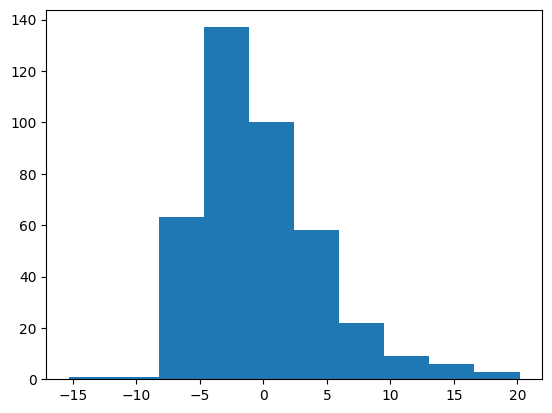

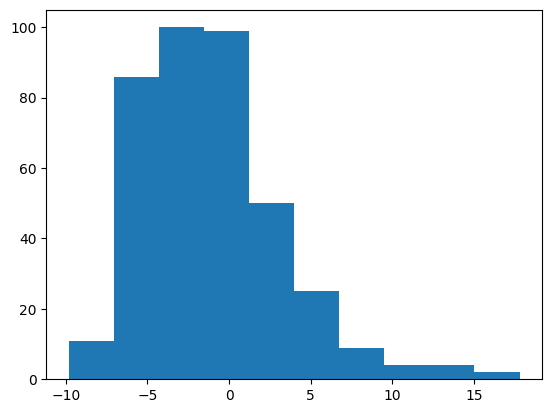

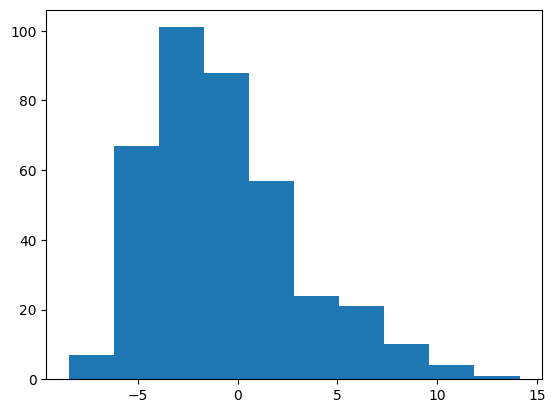

KeyboardInterrupt: 

In [258]:


for i in range(10):
    res_i = torch.tensor([])
    for j in range(10):
        res_i = torch.cat((res_i, aggregated_confidence[j][i][:]))
    plt.hist(res_i[[torch.isfinite(res_i)]])
    plt.show()

(array([ 1.,  2.,  5.,  5.,  8., 11.,  6., 12.,  7.,  3.]),
 array([-4.18615055, -3.80762219, -3.42909408, -3.05056572, -2.6720376 ,
        -2.29350924, -1.91498101, -1.53645277, -1.15792453, -0.77939624,
        -0.400868  ]),
 <BarContainer object of 10 artists>)

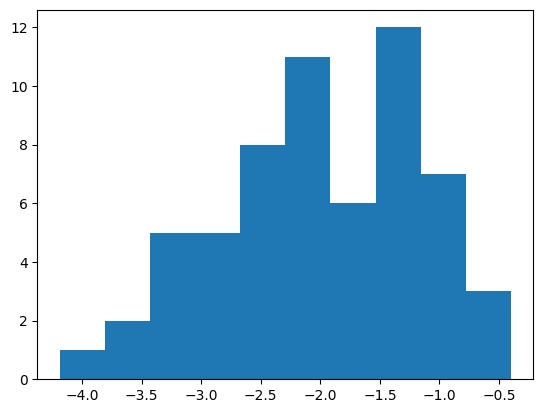

In [254]:
plt.hist(res_i[[torch.isfinite(res_i)]])

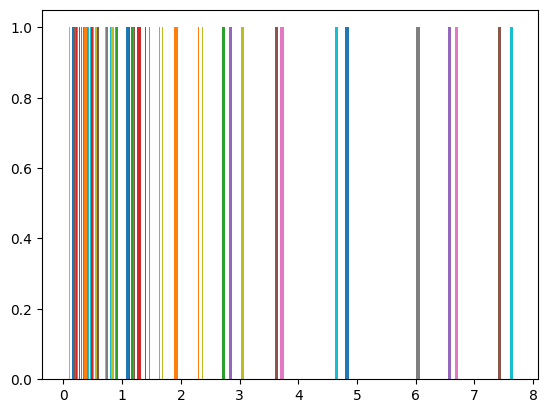

In [179]:
for i in range(9):
    plt.hist(x = outer[i])
    plt.show